# Fitting data with a grid of model spectra

In this tutorial, we will fit spectra and photometric fluxes of [beta Pic b](http://exoplanet.eu/catalog/beta_pic_b/) with the synthetic spectra from an atmospheric model. Here we will use [DRIFT-PHOENIX](https://leap2010blog.wordpress.com/2014/07/03/drift-phoenix-atmosphere-models-creating-new-worlds/) but there are also several [other models supported by *species*](https://species.readthedocs.io/en/latest/overview.html#supported-data).

## Getting started

We start by importing *urllib* and *species*.

In [1]:
import urllib.request
import species

We initiate *species* by running the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html?highlight=SpeciesInit#species.core.setup.SpeciesInit) class. By doing so, both the configuration file and the HDF5 database are created in the working folder.

In [2]:
species.SpeciesInit()

Initiating species v0.3.4... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials


We will also download the GRAVITY $K$ band spectrum of beta Pic b that was obtained by [Gravity Collaboration et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...633A.110G/abstract).

In [3]:
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/species/BetaPictorisb_2018-09-22.fits',
                           'BetaPictorisb_2018-09-22.fits')

('BetaPictorisb_2018-09-22.fits', <http.client.HTTPMessage at 0x10b7056a0>)

## Adding model spectra to the database

Data can be added to the database by creating an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html?highlight=Database#species.data.database.Database).

In [4]:
database = species.Database()

The `Database` object has a number of methods to read and write data. For adding model spectra to the database, we use the [add_model](https://species.readthedocs.io/en/latest/species.data.html?highlight=Database#species.data.database.Database.add_model) method. This method will download the grid of DRIFT-PHOENIX spectra to the *data_folder* path from the configuration file except if the data was already present. After downloading, it will import the spectra into the database. We will only add only a limited range of T$_\mathrm{eff}$ values fewer data needs to be stored and read later on.

In [5]:
database.add_model(model='drift-phoenix', teff_range=(1500., 2000.))

Unpacking DRIFT-PHOENIX model spectra (229 MB)... [DONE]
Adding DRIFT-PHOENIX model spectra... [DONE]                                            
Grid points stored in the database:
   - Teff = [1500. 1600. 1700. 1800. 1900. 2000.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]
   - [Fe/H] = [-0.6 -0.3 -0.   0.3]
Number of grid points per parameter:
   - teff: 6
   - logg: 6
   - feh: 4
Fix missing grid points with a linear interpolation:
   - teff = 1600.0, logg = 3.0, feh = 0.3
   - teff = 1600.0, logg = 5.5, feh = 0.3
   - teff = 1900.0, logg = 4.5, feh = 0.3
   - teff = 1900.0, logg = 5.5, feh = 0.3
Number of stored grid points: 144
Number of interpolated grid points: 4
Number of missing grid points: 0


/Users/tomasstolker/applications/species/species/util/data_util.py:278: RuntimeWarning: divide by zero encountered in log10
  flux = np.log10(flux)


There were 4 grid points missing so these have been interpolated (in log-space) to make it a homogeneous grid.

## Adding photometry and spectra

We will also add [photometric data](https://github.com/tomasstolker/species/blob/master/species/data/companions.py) of beta Pic b that are available in *species* from various references. Let's first have a look from which directly imaged planets there is photometric data available.

In [6]:
database.list_companions()

Object name = beta Pic b
Distance (pc) = 19.75 +/- 0.13
Magellan/VisAO.Ys (mag) = 15.53 +/- 0.34
Paranal/NACO.J (mag) = 14.11 +/- 0.21
Gemini/NICI.ED286 (mag) = 13.18 +/- 0.15
Paranal/NACO.H (mag) = 13.32 +/- 0.14
Paranal/NACO.Ks (mag) = 12.64 +/- 0.11
Paranal/NACO.NB374 (mag) = 11.25 +/- 0.23
Paranal/NACO.Lp (mag) = 11.3 +/- 0.06
Paranal/NACO.NB405 (mag) = 10.98 +/- 0.05
Paranal/NACO.Mp (mag) = 11.1 +/- 0.12

Object name = HIP 65426 b
Distance (pc) = 109.21 +/- 0.75
Paranal/SPHERE.IRDIS_D_H23_2 (mag) = 17.94 +/- 0.05
Paranal/SPHERE.IRDIS_D_H23_3 (mag) = 17.58 +/- 0.06
Paranal/SPHERE.IRDIS_D_K12_1 (mag) = 17.01 +/- 0.09
Paranal/SPHERE.IRDIS_D_K12_2 (mag) = 16.79 +/- 0.09
Paranal/NACO.Lp (mag) = 15.33 +/- 0.12
Paranal/NACO.NB405 (mag) = 15.23 +/- 0.22
Paranal/NACO.Mp (mag) = 14.65 +/- 0.29

Object name = 51 Eri b
Distance (pc) = 29.78 +/- 0.12
MKO/NSFCam.J (mag) = 19.04 +/- 0.4
MKO/NSFCam.H (mag) = 18.99 +/- 0.21
MKO/NSFCam.K (mag) = 18.67 +/- 0.19
Paranal/SPHERE.IRDIS_B_H (mag) = 19.45

To add the photometric data and distance of beta Pic b to the database, we use the [add_companion](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_companion) method, which will also convert the magnitudes into fluxes with a flux-calibrated spectrum of Vega and the filter profiles (downloaded from the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/)). It is also possible to manually add photometric data with the `app_mag` and `flux_density` arguments of [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object), which we will use further below to add the spectra.

In [7]:
database.add_companion(name='beta Pic b')

Adding Vega spectrum... [DONE]
Adding filter: Magellan/VisAO.Ys... [DONE]
Adding filter: Paranal/NACO.J... [DONE]
Adding filter: Gemini/NICI.ED286... [DONE]
Adding filter: Paranal/NACO.H... [DONE]
Adding filter: Paranal/NACO.Ks... [DONE]
Adding filter: Paranal/NACO.NB374... [DONE]
Adding filter: Paranal/NACO.Lp... [DONE]
Adding filter: Paranal/NACO.NB405... [DONE]
Adding filter: Paranal/NACO.Mp... [DONE]
Adding object: beta Pic b
   - Distance (pc) = 19.75 +/- 0.13
   - Magellan/VisAO.Ys:
      - Apparent magnitude = 15.53 +/- 0.34
      - Flux (W m-2 um-1) = 4.27e-15 +/- 1.36e-15
   - Paranal/NACO.J:
      - Apparent magnitude = 14.11 +/- 0.21
      - Flux (W m-2 um-1) = 6.87e-15 +/- 1.34e-15
   - Gemini/NICI.ED286:
      - Apparent magnitude = 13.18 +/- 0.15
      - Flux (W m-2 um-1) = 6.99e-15 +/- 9.69e-16
   - Paranal/NACO.H:
      - Apparent magnitude = 13.32 +/- 0.14
      - Flux (W m-2 um-1) = 5.47e-15 +/- 7.08e-16
   - Paranal/NACO.Ks:
      - Apparent magnitude = 12.64 +/- 0.1

Next, we will add the spectra by using the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method. Make sure to use the same database name as argument of `object_name` such that the spectra are added to the object name for which previously photometric data had been stored with `add_companion`.

The argument of `spectrum` is a dictionary with the names of the spectra as key and a tuple with three elements as value. The first element is a text or FITS file with the spectrum, the second element is the optional covariance matrix, and the third value is the mandatory spectral resolution. The latter is used to smooth the model spectra to the instrument resolution.

For this example, we have adopted the VLTI/GRAVITY $K$ band spectrum from [Gravity Collaboration et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...633A.110G/abstract) and the Gemini/GPI $YJHK$ band spectra from [Chilcote et al. 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....153..182C/abstract). Data that have been stored in the FITS format by the ExoGRAVITY collaboration is automatically recognized so the same FITS filename can be provided as first and second element.

In [8]:
database.add_object('beta Pic b',
                    distance=None,
                    app_mag=None,
                    flux_density=None,
                    spectrum={'GRAVITY': ('BetaPictorisb_2018-09-22.fits', 'BetaPictorisb_2018-09-22.fits', 500.),
                              'GPI\\_Y': ('betapicb_gpi_y.dat', None, 35.),
                              'GPI\\_J': ('betapicb_gpi_j.dat', None, 37.),
                              'GPI\\_H': ('betapicb_gpi_h.dat', None, 46.)},
                              deredden=None)

Adding object: beta Pic b
   - GRAVITY spectrum:
      - Object: Unknown
      - Database tag: GRAVITY
      - Filename: BetaPictorisb_2018-09-22.fits
      - Data shape: (237, 3)
      - Wavelength range (um): 1.97 - 2.49
      - Mean flux (W m-2 um-1): 4.65e-15
      - Mean error (W m-2 um-1): 1.00e-16
   - Spectrum:
      - Database tag: GPI\_Y
      - Filename: betapicb_gpi_y.dat
      - Data shape: (29, 3)
      - Wavelength range (um): 0.98 - 1.13
      - Mean flux (W m-2 um-1): 5.40e-15
      - Mean error (W m-2 um-1): 1.87e-15
   - Spectrum:
      - Database tag: GPI\_J
      - Filename: betapicb_gpi_j.dat
      - Data shape: (32, 3)
      - Wavelength range (um): 1.13 - 1.34
      - Mean flux (W m-2 um-1): 6.84e-15
      - Mean error (W m-2 um-1): 4.79e-16
   - Spectrum:
      - Database tag: GPI\_H
      - Filename: betapicb_gpi_h.dat
      - Data shape: (34, 3)
      - Wavelength range (um): 1.51 - 1.79
      - Mean flux (W m-2 um-1): 5.63e-15
      - Mean error (W m-2 um-1)

The use of `add_object` is incremental so when rerunning the method it will add new data in case a filter or spectrum name hadn't been used before, or it will overwrite existing data in case a filter or spectrum name does already exist. To remove existing data of an object, it is easiest to remove the group of data entirely from the database with the [delete_data](https://species.readthedocs.io/en/latest/species.data.html?highlight=delete_data#species.data.database.Database.delete_data) method of `Database` (e.g. `delete_data('objects/beta Pic b'`) and rerun `add_companion` and/or `add_object`.

## Bayesian inference with nested sampling

To fit the data with the grid of model spectra (i.e. *grid retrieval*), we start by creating an instance of [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html?highlight=FitModel#species.analysis.fit_model.FitModel), which requires the database tag of the object (`beta Pic b`) and the atmosphere model (`drift-phoenix`).

The dictionary of the `bounds` parameter contains the prior boundaries for the various parameters. By default, the parameters of the atmosphere model are set to the full range of the available spectra (e.g. $\log(g)$ and $\mathrm{[Fe/H]}$ in this case).

In addition to the parameters of the atmosphere model, there are several optional parameters can be fitted, for example to account for calibration systematics, extinction, and excess emission from a disk. More details on the various parameters can be found in the (see the documentation of [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html?highlight=FitModel#species.analysis.fit_model.FitModel) for more details). As example, we fit a flux scaling for the different GPI spectra.

The arguments of `inc_phot` and `inc_spec` are either a boolean or a list of photometry and spectra that were previously stored in the database for the object beta Pic b. We will use all the spectra but only the photometric data in the $L$ and $M$ bands.

To account for correlated noise, it is possible to adopt the approach by [Wang et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020AJ....159..263W/abstract) to estimate the covariances by using a Gaussian process. This will add two additional parameters per spectrum (correlation length and amplitude) but is not mandatory. For the example, we only select the GPI $H$ band spectrum, to limit the computation time.

For simplicity we create a list with the 4 filter names that we want to use.

In [9]:
inc_phot = ['Paranal/NACO.Lp', 'Paranal/NACO.NB374', 'Paranal/NACO.NB405', 'Paranal/NACO.Mp']

And create now the instance of [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html?highlight=FitModel#species.analysis.fit_model.FitModel). By doing so, the grid of model spectra will be interpolated to the wavelengths of the data.

In [10]:
fit = species.FitModel(object_name='beta Pic b',
                       model='drift-phoenix',
                       bounds={'teff': (1500., 2000.),
                               'radius': (0.5, 2.),
                               'GPI\\_H': ((0.5, 1.5), None)},
                       inc_phot=inc_phot,
                       inc_spec=True,
                       fit_corr=['GPI\\_H'],
                       weights=None)

Getting object: beta Pic b... [DONE]
Interpolating Paranal/NACO.Lp... [DONE]
Interpolating Paranal/NACO.NB374... [DONE]
Interpolating Paranal/NACO.NB405... [DONE]
Interpolating Paranal/NACO.Mp... [DONE]
Interpolating GPI\_H... [DONE]
Interpolating GPI\_J... [DONE]
Interpolating GPI\_Y... [DONE]
Interpolating GRAVITY... [DONE]
Fitting 7 parameters:
   - teff
   - logg
   - feh
   - radius
   - corr_len_GPI\_H
   - corr_amp_GPI\_H
   - scaling_GPI\_H
Prior boundaries:
   - teff = (1500.0, 2000.0)
   - radius = (0.5, 2.0)
   - logg = (3.0, 5.5)
   - feh = (-0.6, 0.3)
   - corr_len_GPI\_H = (-3.0, 0.0)
   - corr_amp_GPI\_H = (0.0, 1.0)
   - scaling_GPI\_H = (0.5, 1.5)
Weights for the log-likelihood function:
   - GPI\_H = 1.00e+00
   - GPI\_J = 1.00e+00
   - GPI\_Y = 1.00e+00
   - GRAVITY = 1.00e+00
   - Paranal/NACO.Lp = 1.00e+00
   - Paranal/NACO.NB374 = 1.00e+00
   - Paranal/NACO.NB405 = 1.00e+00
   - Paranal/NACO.Mp = 1.00e+00


We are now ready to estimate the posterior distributions by using either [MultiNest](https://johannesbuchner.github.io/PyMultiNest/index.html), [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html), or [emcee](https://emcee.readthedocs.io/en/stable/). It is recommended to use `MultiNest` (see [run_multinest](https://species.readthedocs.io/en/latest/species.analysis.html?highlight=FitModel#species.analysis.fit_model.FitModel.run_multinest) method) or `UltraNest` (see [run_ultranest](https://species.readthedocs.io/en/latest/species.analysis.html?highlight=FitModel#species.analysis.fit_model.FitModel.run_ultranest) method) since these nested sampling algorithms are more powerful in sampling multi-modal distributions. They will also estimate the margenilized likelihood (i.e. *evidence*) which enables pair-wise model comparison through the Bayes factor.

In this example, we will use the [run_ultranest](https://species.readthedocs.io/en/latest/species.analysis.html?highlight=FitModel#species.analysis.fit_model.FitModel.run_ultranest) method of `FitModel`. We specify the database tag were the posterior samples will be stored, the minimum number of live points (see [UltraNest documentation](https://johannesbuchner.github.io/UltraNest/index.html)), the output folder where `UltraNest` will write its data, and we adopt the mass of beta Pic b from [Gravity Collaboration et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...633A.110G/abstract) and use it as a Gaussian prior on the mass (which propagates into $\log(g)$).

Let's now run the parameter estimation with `UltraNest`, which is more straightforward to install than `MultiNest`. Depending on the number of parameters, this can become computationally expensive. The runtime of the nested sampling part of the tutorial was about XX min on MacBook Pro from 2020. For a first attempt, one could also reduce the number of parameters by setting `fit_corr` and scaling parameters to `None`. Using `MultiNest` with a somewhat small number of live points (e.g. `n_live_points=500`) might also be faster.

To speed up the computation, it is possible to run the nested sampling in parellel (e.g. with `mpirun`) to benefit from the multiprocessing support by `UltraNest` and `MultiNest`. In that case it is important that any other functions of `species` that will write to the `Database` will be commented out since simultaneous writing to the HDF5 database by different processes is not possible. It is therefore recommended to first add all the required data to the database and then only run `SpeciesInit`, `FitModel`, and the sampler (`run_multinest` or `run_ultranest`) in parallel with MPI.

In [11]:
import time
start = time.time()
fit.run_ultranest(tag='betapic',
                  min_num_live_points=400,
                  output='ultranest',
                  prior={'mass': (9., 1.6)})
end = time.time()
print(end-start)

Running nested sampling with UltraNest...
Creating directory for new run ultranest/run1
[ultranest] Sampling 400 live points from prior ...


/Users/tomasstolker/.pyenv/versions/3.8.7/envs/general3.8/lib/python3.8/site-packages/ultranest/store.py:194: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'points', dtype=np.float,


[ultranest] Explored until L=1e+04  1485.34 [11484.8498..11484.8506]*| it/evals=11312/484994 eff=2.3343% N=400  
[ultranest] Likelihood function evaluations: 485035


/Users/tomasstolker/.pyenv/versions/3.8.7/envs/general3.8/lib/python3.8/site-packages/ultranest/utils.py:170: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(N, dtype=np.int)


[ultranest] Writing samples and results to disk ...


/Users/tomasstolker/.pyenv/versions/3.8.7/envs/general3.8/lib/python3.8/site-packages/ultranest/utils.py:170: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(N, dtype=np.int)


[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 1.146e+04 +- 0.1523
[ultranest] Effective samples strategy satisfied (ESS = 2660.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.33, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
Log-evidence = 11461.31 +/- 0.33
Best-fit parameters (mean +/- std):
   - teff = 1.72e+03 +/- 4.79e+00
   - logg = 3.98e+00 +/- 4.56e-02
   - feh = 1.33e-01 +/- 1.32e-02
   - radius = 1.50e+00 +/- 1.14e-02
   - corr_len_GPI\_H = -1.51e+00 +/- 1.73e-01
   - corr_amp_GPI\_H = 8.05e-01 +/- 1.03e-01
   - scaling_GPI\_H = 1.13e+00 +/- 2.86e-02
Maximum likelihood sample:
   - Log-likelihood = 11485.34
   - teff = 1720.53
   - logg = 3.99
   - feh = 0.13
   - radius = 1.50
   - corr_len_GPI\_H = -1.56
   - corr_amp_GPI\_H = 0.85
   - scal

## Plotting the posterior samples

The samples from the parameter estimation have been stored in the database. We can now run the [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html?highlight=plot_posterior#species.plot.plot_mcmc.plot_posterior) function to plot the 1D and 2D projections of the posterior distributions by making use of [corner.py](https://corner.readthedocs.io). Here we specify the database tag with the results from `run_ultranest` and we also include the derived posterior for the bolometric luminosity and mass.

In [12]:
species.plot_posterior(tag='betapic',
                       offset=(-0.3 , -0.3),
                       title_fmt=['.0f', '.2f', '.2f', '.2f', '.2f', '.2f', '.2f', '.3f', '.1f'],
                       inc_luminosity=True,
                       inc_mass=True,
                       output='posterior.png')

Median sample:
   - teff = 1721.00
   - logg = 3.98
   - feh = 0.13
   - radius = 1.50
   - corr_len_GPI\_H = -1.50
   - corr_amp_GPI\_H = 0.82
   - scaling_GPI\_H = 1.13
   - distance = 19.75
Plotting the posterior: posterior.png... [DONE]


Let's have a look at the plot!

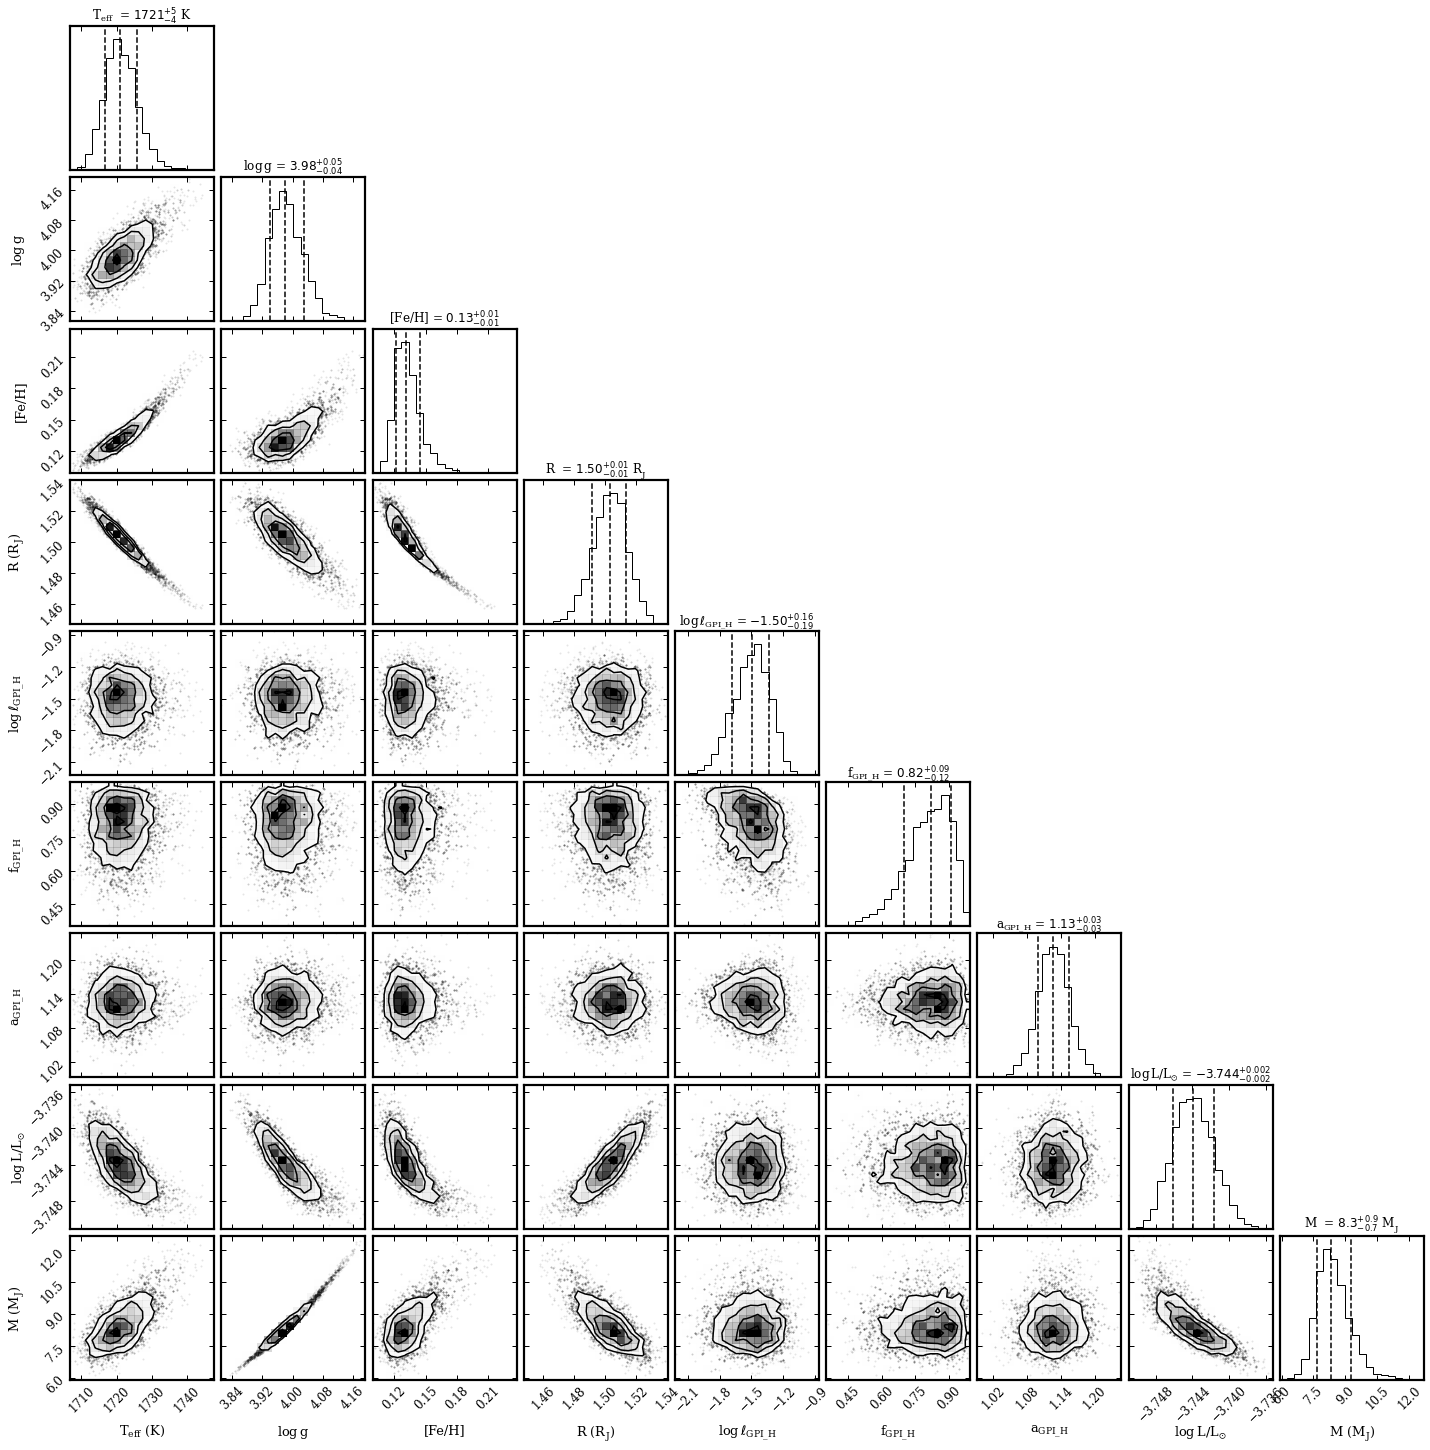

In [13]:
from IPython.display import Image
Image('posterior.png')

## Extracting boxes with results

We will now extract `Box` objects with the results. These will be combined in a plot at the end of the tutorial. We start by selecting 30 random samples from the posterior and use these parameters to interpolate the DRIFT-PHOENIX grid. To do so, we use the [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html?highlight=get_mcmc_#species.data.database.Database.get_mcmc_spectra) method of the `Database`. We will smooth the spectra to a resolution of $R=500$ to match with the resolution of the GRAVITY spectrum.

In [14]:
samples = database.get_mcmc_spectra(tag='betapic',
                                    random=30,
                                    wavel_range=None,
                                    spec_res=500.)

Getting MCMC spectra: 100%|██████████| 30/30 [00:00<00:00, 148.29it/s]


The function returned a list with 30 `ModelBox` objects. Let's have a look at the content of the first box by running the [open_box](https://species.readthedocs.io/en/latest/species.core.html?highlight=open_box#species.core.box.Box.open_box) method. This method can be used for all boxes to easily inspect the attributes of a `Box` object.

In [15]:
samples[0].open_box()

Opening ModelBox...
model = drift-phoenix
type = None
wavelength = [ 0.1         0.10002476  0.10004953 ... 49.97524871 49.98762282
 50.        ]
flux = [1.27651700e-69 1.17718390e-69 1.04929830e-69 ... 2.11694590e-19
 2.11362386e-19 2.11112562e-19]
parameters = {'teff': 1714.0294125547184, 'logg': 3.903783574464812, 'feh': 0.11996762090449209, 'radius': 1.5228018051265184, 'distance': 19.75, 'mass': 7.1687594471076, 'luminosity': 0.00018209605886639136}
quantity = flux


Next, we get the median parameter values with the [get_median_sample](https://species.readthedocs.io/en/latest/species.data.html?highlight=get_median#species.data.database.Database.get_median_sample) method of the `Database` and adopt these as best-fit parameters. Similarly, the [get_probable_sample](https://species.readthedocs.io/en/latest/species.data.html?highlight=get_median#species.data.database.Database.get_probable_sample) method can be used for extracting the sample with the maximum likelihood.

In [16]:
best = database.get_median_sample(tag='betapic')

The best-fit model spectrum is now extracted from the DRIFT-PHOENIX grid by using the functionalities of the [ReadModel](https://species.readthedocs.io/en/latest/species.read.html?highlight=ReadModel#species.read.read_model.ReadModel) class.

In [17]:
read_model = species.ReadModel(model='drift-phoenix',
                               wavel_range=None)

The grid is interpolated at the best-fit parameters with the [get_model](https://species.readthedocs.io/en/latest/species.read.html?highlight=ReadModel#species.read.read_model.ReadModel.get_model). The argument of `model_param` contains the parameter dictionary that was returned by `get_median_sample`. The spectrum will be smoothed to a resolution of $R=500$. To extract the spectrum without smoothing at the resolution as stored in the database is achieved by setting the argument of `spec_res` to `None` and `smooth` to `False`.

In [18]:
modelbox = read_model.get_model(model_param=best,
                                spec_res=500.,
                                smooth=True)

/Users/tomasstolker/applications/species/species/read/read_model.py:595: UserWarning: The 'corr_len_GPI\_H' parameter is not required by 'drift-phoenix' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(f'The \'{key}\' parameter is not required by \'{self.model}\' so '
/Users/tomasstolker/applications/species/species/read/read_model.py:595: UserWarning: The 'corr_amp_GPI\_H' parameter is not required by 'drift-phoenix' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(f'The \'{key}\' parameter is not required by \'{self.model}\' so '
/Users/tomasstolker/applications/species/species/read/read_model.py:595: UserWarning: The 'scaling_GPI\_H' parameter is not required by 'drift-phoenix' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(f'The \'{key}\' parameter is not required by \'{self.model}\' so '


Some warnings are printed because the dictionary provided to `model_param` contained calibration parameters that were fitted, but these are not required when reading a model spectrum.

We will also extract all spectra and photometric fluxes of beta Pic b with the [get_object](https://species.readthedocs.io/en/latest/species.data.html?highlight=get_object#species.data.database.Database.get_object) method of the `Database` object.

In [19]:
objectbox = database.get_object(object_name='beta Pic b',
                                inc_phot=True,
                                inc_spec=True)

Getting object: beta Pic b... [DONE]


Let's have a look at the content of the `ObjectBox`.

In [20]:
objectbox.open_box()

Opening ObjectBox...
name = beta Pic b
filters = ['Gemini/NICI.ED286', 'Magellan/VisAO.Ys', 'Paranal/NACO.H', 'Paranal/NACO.J', 'Paranal/NACO.Ks', 'Paranal/NACO.Lp', 'Paranal/NACO.Mp', 'Paranal/NACO.NB374', 'Paranal/NACO.NB405']
magnitude = {'Gemini/NICI.ED286': array([13.18,  0.15]), 'Magellan/VisAO.Ys': array([15.53,  0.34]), 'Paranal/NACO.H': array([13.32,  0.14]), 'Paranal/NACO.J': array([14.11,  0.21]), 'Paranal/NACO.Ks': array([12.64,  0.11]), 'Paranal/NACO.Lp': array([11.3 ,  0.06]), 'Paranal/NACO.Mp': array([11.1 ,  0.12]), 'Paranal/NACO.NB374': array([11.25,  0.23]), 'Paranal/NACO.NB405': array([10.98,  0.05])}
flux = {'Gemini/NICI.ED286': array([6.98948226e-15, 9.68707404e-16]), 'Magellan/VisAO.Ys': array([4.26525692e-15, 1.35760940e-15]), 'Paranal/NACO.H': array([5.47258430e-15, 7.07618199e-16]), 'Paranal/NACO.J': array([6.86840623e-15, 1.33676609e-15]), 'Paranal/NACO.Ks': array([4.04416805e-15, 4.10431111e-16]), 'Paranal/NACO.Lp': array([1.58988155e-15, 8.79048273e-17]), 'P

We then run the `ObjectBox` through the [update_spectra](https://species.readthedocs.io/en/latest/species.util.html?highlight=update_spectra#species.util.read_util.update_spectra) utility function with the best-fit parameters. This function applies the flux scaling and could also inflate the errors in case an error inflation was fitted.

In [21]:
objectbox = species.update_spectra(objectbox=objectbox,
                                   model_param=best)

Scaling the flux of GPI\_H: 1.13... [DONE]


Next, we calculate the residuals of the best-fit model with [get_residuals](https://species.readthedocs.io/en/latest/species.util.html?highlight=update_spectra#species.util.phot_util.get_residuals). This function will interpolate the spectrum, calculate synthetic photometry for the filters provided as argument of `inc_phot`, and smooth and resample the spectra to the resolution and wavelengths of the spectra provided as argument of `inc_spec` (all spectra of the `ObjectBox` in this case).

In [22]:
residuals = species.get_residuals(datatype='model',
                                  spectrum='drift-phoenix',
                                  parameters=best,
                                  objectbox=objectbox,
                                  inc_phot=inc_phot,
                                  inc_spec=True)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals (sigma):
   - Paranal/NACO.Lp: -4.68
   - Paranal/NACO.NB374: -1.10
   - Paranal/NACO.NB405: -0.69
   - Paranal/NACO.Mp: -0.78
   - GPI\_H: min: -1.34, max: 2.09
   - GPI\_J: min: -1.99, max: 4.06
   - GPI\_Y: min: -1.29, max: 1.37
   - GRAVITY: min: -5.69, max: 5.15


The residuals have been stored in a `ResidualsBox`. Let's have a look at its content.

In [23]:
residuals.open_box()

Opening ResidualsBox...
name = beta Pic b
photometry = {'Paranal/NACO.Lp': array([ 3.80502844, -4.68377313]), 'Paranal/NACO.NB374': array([ 3.7448051, -1.1033019]), 'Paranal/NACO.NB405': array([ 4.05586338, -0.68678139]), 'Paranal/NACO.Mp': array([ 4.78097105, -0.7766498 ])}
spectrum = {'GPI\\_H': array([[ 1.51142699, -0.49587148],
       [ 1.5198378 , -0.39673214],
       [ 1.52824861, -0.28301895],
       [ 1.53665942, -0.00609008],
       [ 1.54507023, -0.25207751],
       [ 1.55348104, -0.22610689],
       [ 1.56189185, -0.3688381 ],
       [ 1.57030267, -0.60318585],
       [ 1.57871348, -0.67451616],
       [ 1.58712429, -0.52845552],
       [ 1.5955351 , -0.64803487],
       [ 1.60394591, -0.44346971],
       [ 1.61235672, -0.60353105],
       [ 1.62076753, -0.55350809],
       [ 1.62917835, -0.81981025],
       [ 1.63758916, -0.96756582],
       [ 1.64599997, -1.0597471 ],
       [ 1.65441078, -1.13935698],
       [ 1.66282159, -1.28181463],
       [ 1.6712324 , -1.33808419],
 

Finally, we compute synthetic photometry from the best-fit model spectrum with the [multi_photometry](https://species.readthedocs.io/en/latest/species.util.html?highlight=multi_phot#species.util.phot_util.multi_photometry) function. Since we will plot all available photometric data of the `ObjectBox`, we will also calculate synthetic photometry for all the filter names of the `filters` attribute of the `ObjectBox`.

In [24]:
synphot = species.multi_photometry(datatype='model',
                                   spectrum='drift-phoenix',
                                   filters=objectbox.filters,
                                   parameters=best)

Calculating synthetic photometry... [DONE]


Let's open the `SynphotBox`.

In [25]:
synphot.open_box()

Opening SynphotBox...
name = synphot
flux = {'Gemini/NICI.ED286': 6.329510453909333e-15, 'Magellan/VisAO.Ys': 3.2603743800629753e-15, 'Paranal/NACO.H': 6.036479978937338e-15, 'Paranal/NACO.J': 6.404996403680485e-15, 'Paranal/NACO.Ks': 4.982990311364488e-15, 'Paranal/NACO.Lp': 2.001607816373126e-15, 'Paranal/NACO.Mp': 8.531904771137991e-16, 'Paranal/NACO.NB374': 2.0918909842906338e-15, 'Paranal/NACO.NB405': 1.6609800183133947e-15}


## Plotting the spectral energy distribution

Now that we have gather all the `Box` objects with the results, we can pass them as list to the `boxes` parameter of the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html?highlight=plot_spectrum#species.plot.plot_spectrum.plot_spectrum) function. The `ResidualsBox` is separately provided as argument of `residuals`. We also include a list of filter name for which the filter profiles will be plotted. The arguments of `residuals` and `filters` can also be set to `None` to not include these data in the plot. The somewhat complex part of `plot_spectrum` is the optional `plot_kwargs` parameter. The argument is a list with the same length as the list of `boxes`. Each item contains a dictionary with keyword arguments that will be used to style the plot. The item of the `SynphotBox` can be set to `None` because it is automatically adjusted to the style that is set for the `ObjectBox`.

In [32]:
species.plot_spectrum(boxes=[samples, modelbox, objectbox, synphot],
                      filters=objectbox.filters,
                      residuals=residuals,
                      plot_kwargs=[{'ls': '-', 'lw': 0.2, 'color': 'gray'},
                                   {'ls': '-', 'lw': 1., 'color': 'black'},
                                   {'GRAVITY': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'tab:pink', 'ls': 'none', 'alpha': 0.5, 'label': 'VLTI/GRAVITY'},
                                    'GPI\\_Y': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'tab:green', 'ls': 'none', 'alpha': 0.5, 'label': 'Gemini/GPI'},
                                    'GPI\\_J': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'tab:green', 'ls': 'none', 'alpha': 0.5},
                                    'GPI\\_H': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'tab:green', 'ls': 'none', 'alpha': 0.5},
                                    'Magellan/VisAO.Ys': {'marker': 's', 'ms': 5., 'color': 'tab:purple', 'ls': 'none', 'label': 'Magellan/VisAO'},
                                    'Gemini/NICI.ED286': {'marker': 's', 'ms': 5., 'color': 'tab:orange', 'ls': 'none', 'label': 'Gemini/NICI'},
                                    'Paranal/NACO.J': {'marker': 's', 'ms': 5., 'color': 'tab:blue', 'ls': 'none', 'label': 'VLT/NACO'},
                                    'Paranal/NACO.H': {'marker': 's', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.Ks': {'marker': 's', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.NB374': {'marker': 's', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.Lp': {'marker': 's', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.NB405': {'marker': 's', 'markersize': 5., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.Mp': {'marker': 's', 'markersize': 5., 'color': 'tab:blue', 'ls': 'none'}},
                                    None],
                      xlim=(0.8, 5.2),
                      ylim=(-1.15e-15, 1.15e-14),
                      ylim_res=(-7., 7.),
                      scale=('linear', 'linear'),
                      offset=(-0.4, -0.05),
                      legend=[{'loc': 'lower left', 'frameon': False, 'fontsize': 11.},
                              {'loc': 'upper right', 'frameon': False, 'fontsize': 11.}],
                      figsize=(8., 4.),
                      quantity='flux density',
                      output='spectrum.png')

Plotting spectrum: spectrum.png... [DONE]


Let's have a look at the result!

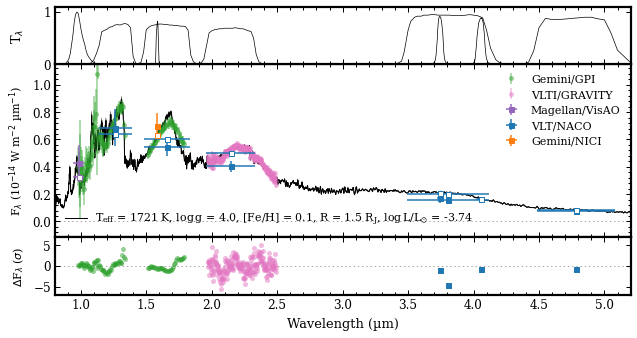

In [33]:
Image('spectrum.png')